In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [15]:
df = pd.read_csv('/content/network-security-white-labelling/resources/amazon/amazon_smart_wifi_plug_products_dataset.csv')
df = df[df['brand']!="None"]

In [8]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [stemmer.stem(token) for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

df['processed_long_description'] = df['long_description'].apply(preprocess_text)

In [18]:
aggregated_data = df.groupby('brand')['processed_long_description'].apply(lambda x: ' '.join(x)).reset_index()


In [20]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(aggregated_data['processed_long_description'])
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
aggregated_data['cluster'] = kmeans.fit_predict(tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
for cluster_num in range(num_clusters):
    print(f"Cluster {cluster_num + 1}:")
    print(aggregated_data[aggregated_data['cluster'] == cluster_num]['brand'].tolist())
    print()


Cluster 1:
['BORDSTRACT', 'Dioche', 'EZVIZ', 'FTVOGUE', 'Garosa', 'Hyuduo', 'LUCKDANO', 'Lazmin112', 'Marhynchus', 'Pomya', 'Premier Accessory Group', 'YOUTHINK', 'YWBL-WH', 'plplaaobo']

Cluster 2:
['Airshi', 'Bediffer', 'Biitfuu', 'Boxwizard', 'DEMYA', 'Diydeg', 'Dyegold', 'EBTOOLS', 'EMUKOEP', 'ERYUE', 'EVGATSAUTO', 'Eujgoov', 'Fafeicy', 'Hilitand', 'Honio', 'Hztyyier', 'IUPPA', 'JIJO', 'Jauarta', 'KOSDFOGE', 'Kadimendium', 'LBEC', 'LiebeWH', 'Marukio', 'NATWEE', 'NOVAZEN', 'Odorkle', 'Orenic', 'Pyhodi', 'Qiilu', 'Restokki', 'Shanrya', 'TOUISEDGI', 'Tgoon', 'Tyenaza', 'VTOSEN', 'Walfront', 'Wisecoco', 'Ymiko', 'Yuecoom', 'plplaaoo']

Cluster 3:
['3GRACE', 'Abida', 'Alpha Digital', 'Athom', 'Brilliant', 'Deco Essentials', 'ELEGRP', 'EVA BELLE', 'Eaton', 'Enbrighten', 'Etekcity', 'Filotimo', 'Gantch', 'Gaoducash', 'Geeni', 'Goldlife', 'HEB', 'Inkbird', 'JAMCHE', 'Kungfuking', 'LANTRO JS', 'Lenovo', 'Leviton', 'Linkind', 'MOES', 'MXQ', 'Maxpw', 'NETGEAR', 'ONVIS', 'Otcboimo', 'PHOVOLT'

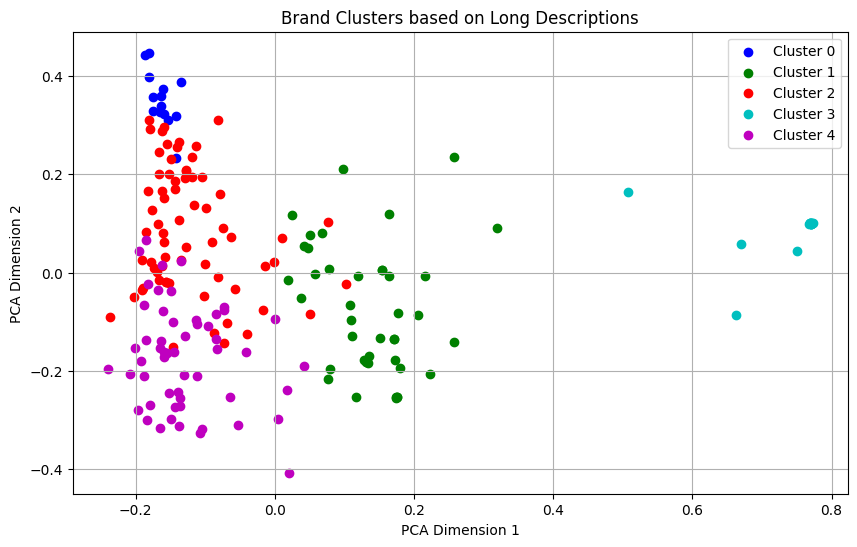

In [25]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

aggregated_data['pca_1'] = pca_result[:, 0]
aggregated_data['pca_2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for cluster_num in range(num_clusters):
    cluster_data = aggregated_data[aggregated_data['cluster'] == cluster_num]
    plt.scatter(cluster_data['pca_1'], cluster_data['pca_2'], label=f'Cluster {cluster_num}', color=colors[cluster_num])

plt.title('Brand Clusters based on Long Descriptions')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

## Clustering using BERT

In [28]:
from transformers import BertTokenizer, BertModel
import torch


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

In [33]:
tokenized_data = [tokenizer(text, padding=True, truncation=True, return_tensors="pt") for text in aggregated_data["processed_long_description"]]
embeddings = []

for item in tokenized_data:
    with torch.no_grad():
        output = model(**item)
        embeddings.append(output.last_hidden_state.mean(dim=1).squeeze().numpy())

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(embeddings)
aggregated_data["cluster_bert"] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


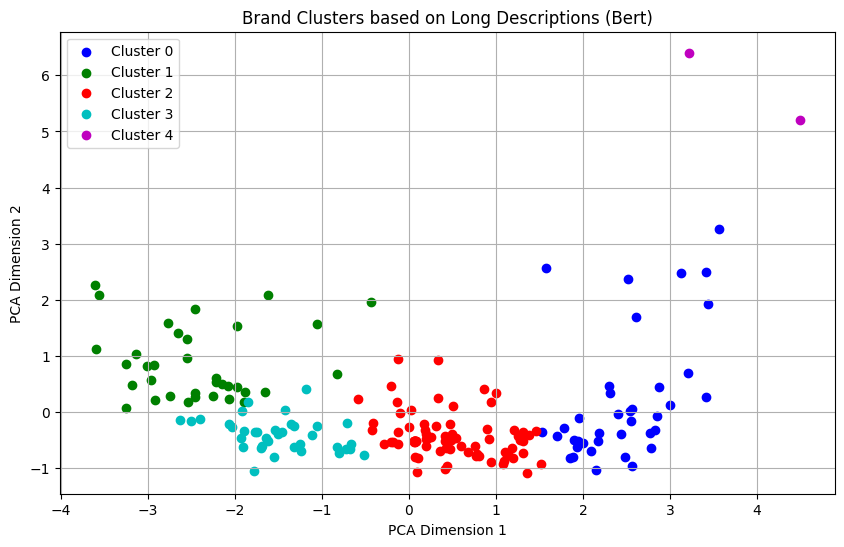

In [35]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Add PCA results to the DataFrame
aggregated_data['pca_1_bert'] = pca_result[:, 0]
aggregated_data['pca_2_bert'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for cluster_num in range(num_clusters):
    cluster_data = aggregated_data[aggregated_data['cluster_bert'] == cluster_num]
    plt.scatter(cluster_data['pca_1_bert'], cluster_data['pca_2_bert'], label=f'Cluster {cluster_num}', color=colors[cluster_num])

plt.title('Brand Clusters based on Long Descriptions (Bert)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.grid(True)
plt.show()